## **Import các thư viện cần thiết**

In [231]:
import warnings
warnings.filterwarnings('ignore')
from transform import PreProcessing
%matplotlib inline

import wordcloud
import nltk


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from collections import Counter
from inspect import signature
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import ShuffleSplit


import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
warnings.filterwarnings("ignore")

## **Đọc dữ liệu**

In [232]:
df = pd.read_csv('data/vnxpress.csv', encoding='utf-8')

In [233]:
df

,content,label
0,Tôi thấy nếu đã gửi thông báo mà sàn thương mạ...,0
1,Người VN mình tự đầu độc nhau trên các sàn và ...,2
2,"Có lợi nhuận thì họ kinh doanh thôi, cái quan ...",2
3,"Làm mà không được thì tự chịu, làm mà trôi chả...",2
4,Vấn đề đó không liên quan ở đây bạn ạ. Nếu đã ...,0
...,...,...
6969,"chụp CT thì bth thôi, 2 3 tháng chụp là bth, t...",2
6970,"Không sao đâu chú, liều y tế quy định nên suất...",1
6971,Lương cao lắm,0
6972,Quan trọng là sức khoẻ. Lương cao thì xứng đán...,0


# Tiền xử lý

In [234]:
print('Dataset columns, rows:', df.shape)
print('How many labels and their counts?:', df['label'].value_counts())
label_counts = df['label'].value_counts()

Dataset columns, rows: (6974, 2)
How many labels and their counts?: label
2    2794
0    2232
1    1948
Name: count, dtype: int64


In [235]:
df = df.drop_duplicates("content") # drop duplicates
df = df.dropna() # drop null
print('How many label and their count left?:', df['label'].value_counts())

How many label and their count left?: label
2    2789
0    2227
1    1938
Name: count, dtype: int64


In [236]:
df['corpus'] = df['content'].apply(lambda x: PreProcessing(x).norm() if isinstance(x, str) else '')
df

,content,label,corpus
0,Tôi thấy nếu đã gửi thông báo mà sàn thương mạ...,0,gửi thông_báo sàn thương_mại điện_tử bất_kỳ cu...
1,Người VN mình tự đầu độc nhau trên các sàn và ...,2,việt nam đầu_độc sàn mạng xã_hội lướt vòng hàn...
2,"Có lợi nhuận thì họ kinh doanh thôi, cái quan ...",2,lợi_nhuận kinh_doanh quan_trọng vì_sao hàng gi...
3,"Làm mà không được thì tự chịu, làm mà trôi chả...",2,trôi_chảy kiểu đơn_vị hỏi_thăm mệt_mỏi
4,Vấn đề đó không liên quan ở đây bạn ạ. Nếu đã ...,0,vấn_đề liên_quan đấy hàng giả nhái giá rẻ chất...
...,...,...,...
6969,"chụp CT thì bth thôi, 2 3 tháng chụp là bth, t...",2,chụp chủ_tịch bình_thường 2 3 chụp bình_thường...
6970,"Không sao đâu chú, liều y tế quy định nên suất...",1,liều y_tế quy_định suất liều chụp phép an_tâm ...
6971,Lương cao lắm,0,lương lắm
6972,Quan trọng là sức khoẻ. Lương cao thì xứng đán...,0,quan_trọng sức_khoẻ lương xứng_đáng rủi_ro côn...


# EDA

In [237]:
all_words = [] 
for index, row in df.iterrows():
    sentence = row['corpus']
    words = sentence.split()
    all_words.extend(words)
all_words = [word for word in all_words if word and word != ' ']
corpus=' '.join(all_words)
all_words = nltk.FreqDist(all_words)

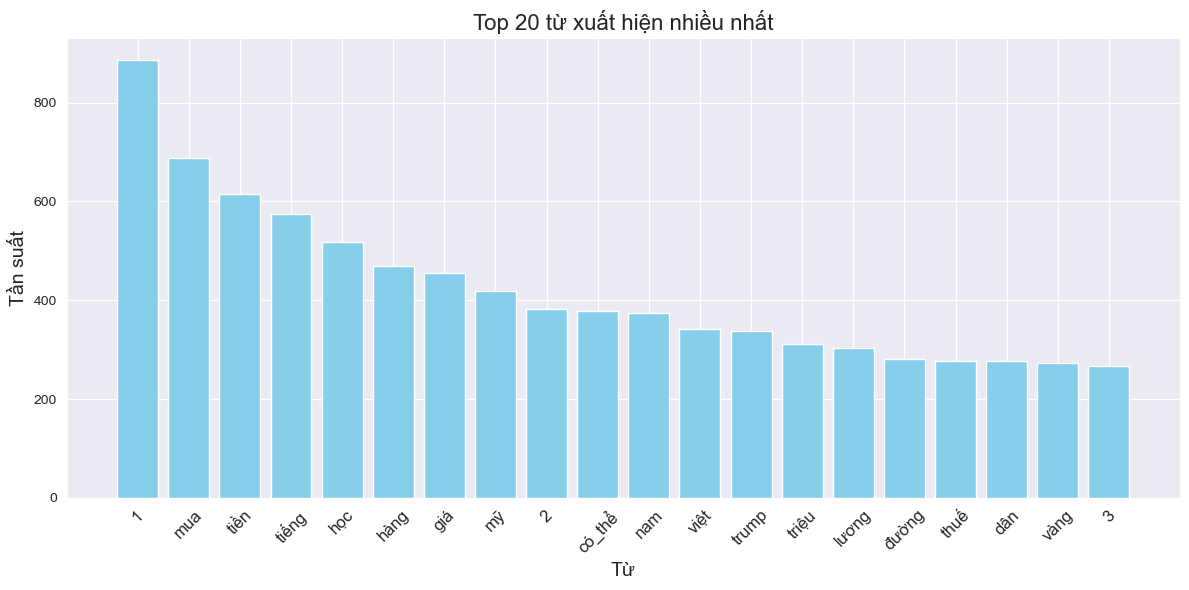

In [238]:
most_common_words = all_words.most_common(20)
words, counts = zip(*most_common_words)
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Từ', fontsize=14)
plt.ylabel('Tần suất', fontsize=14)
plt.title('Top 20 từ xuất hiện nhiều nhất', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

In [239]:
print('Number of words: {}'.format(len(all_words)))

Number of words: 9660


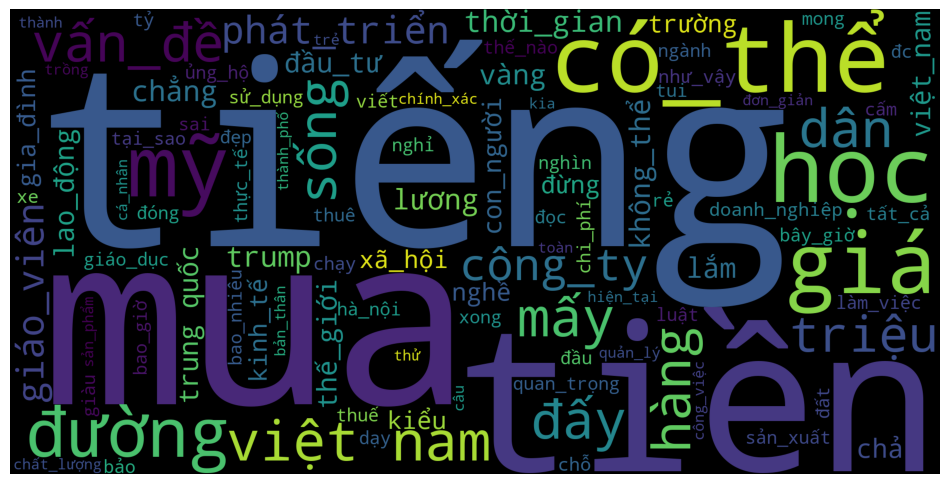

In [240]:
plt.figure(figsize=(12,8))
word_cloud = wordcloud.WordCloud(max_words=100,background_color ="black",
                               width=2000,height=1000,mode="RGB").generate(corpus)
plt.axis("off")
plt.imshow(word_cloud)

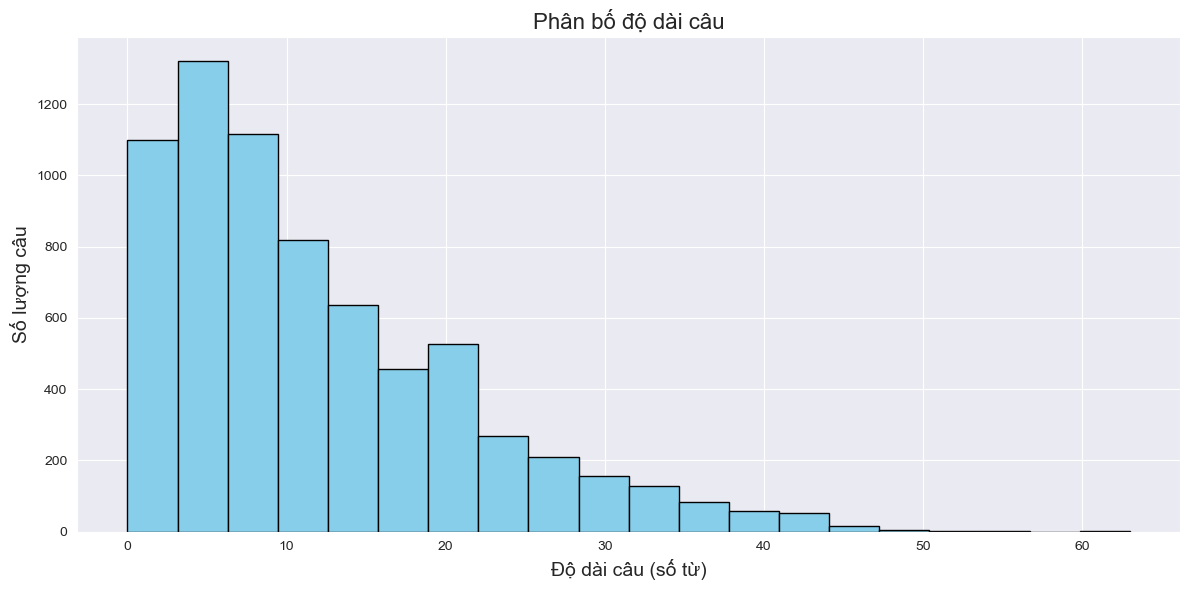

In [241]:
df['sentence_length'] = df['corpus'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
plt.hist(df['sentence_length'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Độ dài câu (số từ)', fontsize=14)
plt.ylabel('Số lượng câu', fontsize=14)
plt.title('Phân bố độ dài câu', fontsize=16)
plt.tight_layout()
plt.show()

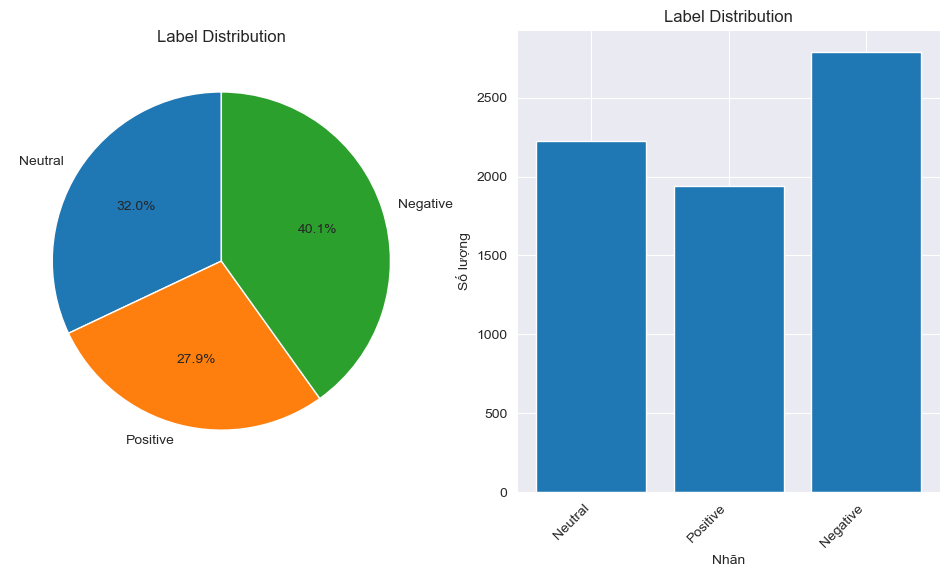

In [242]:
label_counts = df['label'].value_counts().sort_index()
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
labels = ['Neutral', 'Positive', 'Negative']  # updated labels
ax[0].pie(label_counts, labels=labels, autopct='%1.1f%%', startangle=90)
ax[0].set_title('Label Distribution')
plt.bar(label_counts.index, label_counts.values)
plt.xlabel("Nhãn")
plt.ylabel("Số lượng")
plt.title("Label Distribution")
plt.xticks(label_counts.index, labels, rotation=45, ha='right')
plt.show()

In [243]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(
    df['corpus'],
    df['label'],
    test_size=0.3,
    random_state=42
)

# Oversampled

In [244]:
pos_indices = np.where(train_labels == 1)[0]
oversample_size = len(train_labels[train_labels == 0]) - len(pos_indices) 
oversampled_indices = resample(pos_indices, replace=True, n_samples=oversample_size)
oversampled_neutral_sentences = np.array(train_sentences)[oversampled_indices]

train_sentences_oversampled = np.concatenate([train_sentences, oversampled_neutral_sentences], axis=0)
train_labels_oversampled = np.concatenate([train_labels, np.array([1] * oversample_size)], axis=0)

In [245]:
unique_labels, counts = np.unique(train_labels_oversampled, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count}")

Label 0: 1545
Label 1: 1545
Label 2: 1952


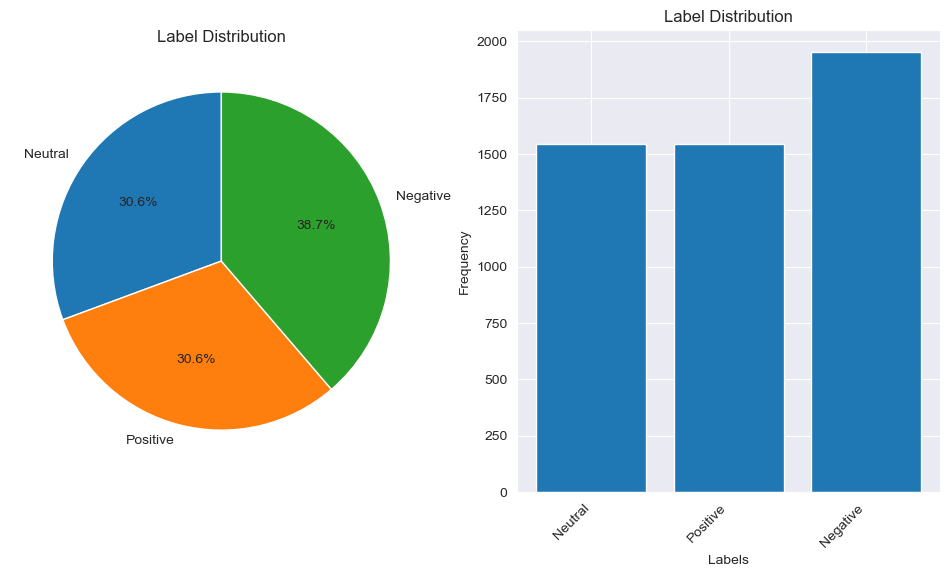

In [246]:
label_counts = pd.Series(train_labels_oversampled).value_counts().sort_index()
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
labels = ['Neutral', 'Positive', 'Negative']
ax[0].pie(label_counts, labels=labels, autopct='%1.1f%%', startangle=90)
ax[0].set_title('Label Distribution')
plt.bar(label_counts.index, label_counts.values)
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Label Distribution")
plt.xticks(label_counts.index, labels, rotation=45, ha='right')
plt.show()

# Tokenization

In [247]:
vectorizer = CountVectorizer()
vectorizer.fit(train_sentences)

CountVectorizer()

In [248]:
MAX_VOCAB_LENGTH = 20000
sequence_lengths = [len(sentence.split()) for sentence in train_sentences]
MAX_LENGTH = int(np.percentile(sequence_lengths, 95))

In [249]:
tokenizer = get_tokenizer("basic_english")
def build_vocab(sentences, max_tokens):
    tokens = []
    for sent in sentences:
        tokens.extend(tokenizer(sent))
    counter = Counter(tokens)
    sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse = True)
    vocab = [token for token, freq in sorted_by_freq_tuples[:max_tokens]]
    vocab.insert(0, "<UNK>")
    token_to_index = {token: idx for idx, token in enumerate(vocab)}
    return token_to_index

token_to_index = build_vocab(train_sentences, MAX_VOCAB_LENGTH)

In [250]:
def text_to_indices(sentence, token_to_index, max_length):
    tokens = tokenizer(sentence)
    indices = [token_to_index.get(token, token_to_index["<UNK>"]) for token in tokens]

    if len(indices) < max_length:
      indices += [0] * (max_length - len(indices))
    elif len(indices) > max_length:
       indices = indices[:max_length]
    return torch.tensor(indices)

In [251]:
vectorized_train_sentences = [text_to_indices(sent, token_to_index, MAX_LENGTH) for sent in train_sentences_oversampled]
vectorized_train_sentences = torch.stack(vectorized_train_sentences)

vectorized_test_sentences = [text_to_indices(sent, token_to_index, MAX_LENGTH) for sent in test_sentences]
vectorized_test_sentences = torch.stack(vectorized_test_sentences)

vectorized_all = torch.cat((vectorized_train_sentences, vectorized_test_sentences), dim=0)

In [252]:
train_labels_tensor = torch.tensor(train_labels_oversampled, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels.values, dtype=torch.long)
labels_all_tensor = torch.cat((train_labels_tensor, test_labels_tensor), dim=0)
labels_all_np = labels_all_tensor.numpy()

print("Shape of vectorized train sentences:", vectorized_train_sentences.shape)
print("Shape of vectorized test sentences:", vectorized_test_sentences.shape)
print("Shape of train labels:", train_labels_tensor.shape)
print("Shape of test labels:", test_labels_tensor.shape)
print("Shape of vectorized all sentences:", vectorized_all.shape)

Shape of vectorized train sentences: torch.Size([5042, 31])
Shape of vectorized test sentences: torch.Size([2087, 31])
Shape of train labels: torch.Size([5042])
Shape of test labels: torch.Size([2087])
Shape of vectorized all sentences: torch.Size([7129, 31])


In [253]:
# 1. TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_sentences_oversampled)
X_test = vectorizer.transform(test_sentences)
y_train = train_labels_oversampled
y_test = test_labels.values

# Random Forest


In [254]:
def perform_grid_search(X, y, param_grid, cv_splits=5):
    rf = RandomForestClassifier(random_state=42)
    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)

    grid_search.fit(X, y)
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Score: {grid_search.best_score_}")
    return grid_search.best_estimator_

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'criterion': ['gini', 'entropy']
}

best_model = perform_grid_search(X_train, y_train, param_grid)

Best Parameters: {'criterion': 'gini', 'n_estimators': 50}
Best Score: 0.5140871049443894


In [255]:
def plot_scores(title, xlabel, x_values, score_mean, ylabel='Accuracy'):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)

    plt.errorbar(x_values, score_mean, fmt='o-', capsize=5)
    plt.xticks(x_values)
    plt.show()

100%|██████████| 5/5 [05:02<00:00, 60.45s/it]


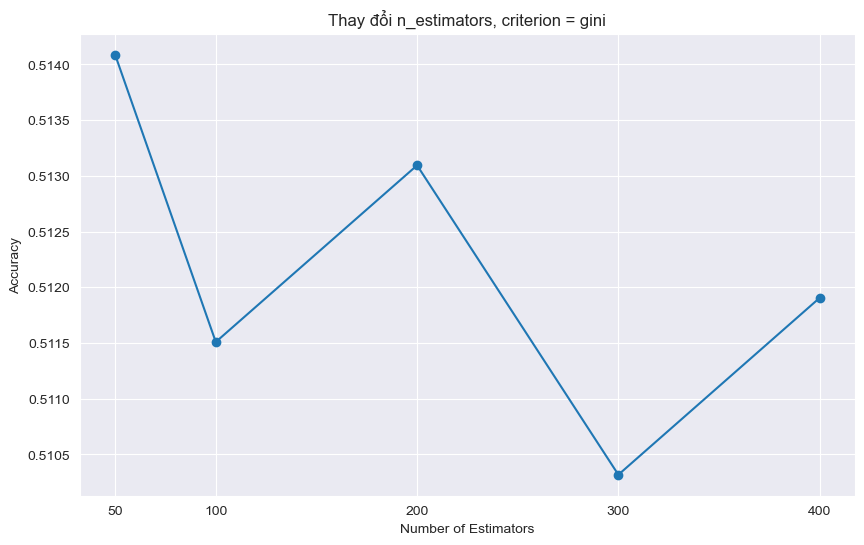

In [300]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

n_estimators = [50, 100, 200, 300, 400]
criterion = 'gini'
score_mean = []
score_std = []

for n_est in tqdm(n_estimators):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    model = RandomForestClassifier(n_estimators=n_est, criterion=criterion, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)
    score_mean.append(scores.mean())

plot_scores('Thay đổi n_estimators, criterion = gini', 'Number of Estimators', n_estimators, score_mean)

100%|██████████| 2/2 [02:29<00:00, 74.93s/it]


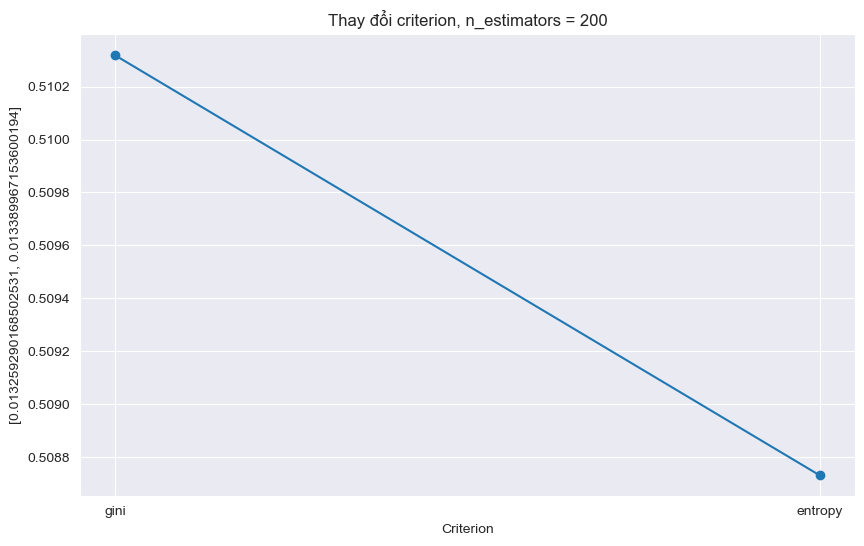

In [257]:
n_estimators = 50
criterion = ['gini', 'entropy']
score_mean = []
score_std = []

for crit in tqdm(criterion):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    model = RandomForestClassifier(n_estimators=n_estimators, criterion=crit, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)

    score_mean.append(scores.mean())
    score_std.append(scores.std())

plot_scores('Thay đổi criterion, n_estimators = 200', 'Criterion', criterion, score_mean, score_std)

# SVM

In [258]:
def perform_grid_search_svm(X, y, param_grid, cv_splits=5):
    svm = SVC(random_state=42)
    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)

    grid_search.fit(X, y)
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Score: {grid_search.best_score_}")
    return grid_search.best_estimator_

# Example usage
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

best_svm_model = perform_grid_search_svm(X_train, y_train, svm_param_grid)

Best Parameters: {'C': 10, 'kernel': 'rbf'}
Best Score: 0.5176559771579592


100%|██████████| 4/4 [00:15<00:00,  3.82s/it]


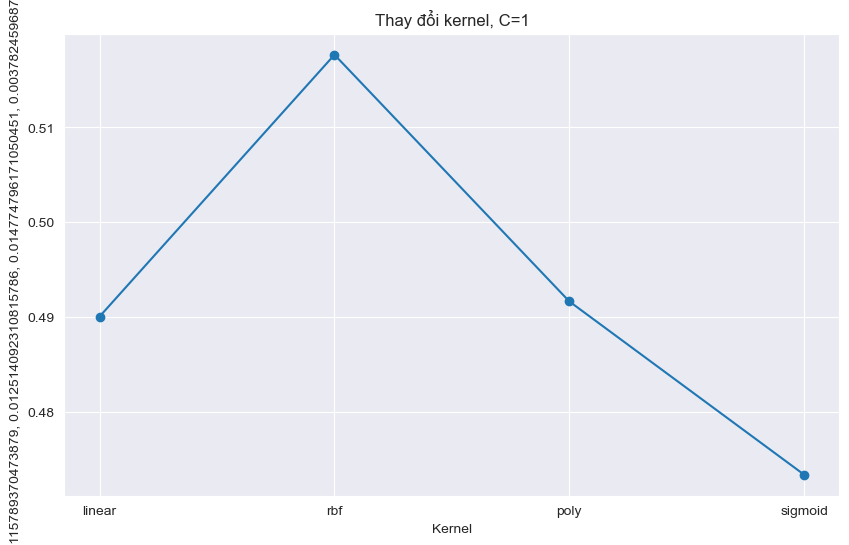

In [302]:
kernel = ['linear', 'rbf', 'poly', 'sigmoid']
C = 10
score_mean = []
score_std = []

for k in tqdm(kernel):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    model = SVC(C=C, kernel=k, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)

    score_mean.append(scores.mean())
    score_std.append(scores.std())

plot_scores('Thay đổi kernel, C=1', 'Kernel', kernel, score_mean, score_std)

100%|██████████| 6/6 [00:20<00:00,  3.45s/it]


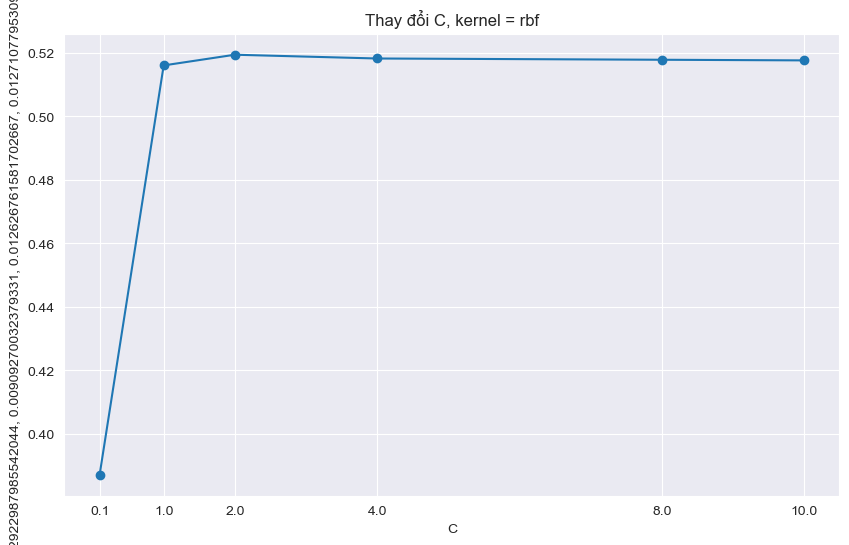

In [303]:
C = [0.1, 1, 2, 4, 8, 10]
kernel = 'rbf'
score_mean = []
score_std = []

for c in tqdm(C):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    model = SVC(C=c, kernel=kernel, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)

    score_mean.append(scores.mean())
    score_std.append(scores.std())

plot_scores('Thay đổi C, kernel = rbf', 'C', C, score_mean, score_std)

# Logistic

In [261]:
def perform_grid_search_logistic(X, y, param_grid, cv_splits=5):
    logistic = LogisticRegression(random_state=42, max_iter=1000)
    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=logistic, param_grid=param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X, y)
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Score: {grid_search.best_score_}")
    return grid_search.best_estimator_

logistic_param_grid = {
'C': [0.01, 0.1, 1, 10, 100],
'penalty': ['l1', 'l2', 'elasticnet', 'none']
}

best_logistic_model = perform_grid_search_logistic(X_train, y_train, logistic_param_grid)

Best Parameters: {'C': 1, 'penalty': 'l2'}
Best Score: 0.5099214214922838


# Training

In [304]:
def train_and_evaluate_model(X_train, y_train, X_test, y_test, model_type='svm', n_splits=5):
    """Huấn luyện và đánh giá mô hình SVM, Logistic Regression hoặc Random Forest."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_fold_data = []
    all_reports = []
    all_conf_matrices = []
    all_precisions = []
    all_recalls = []
    all_f1s = []

    for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
        print(f"Fold {fold + 1}/{n_splits}")
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        if model_type == 'svm':
            model = SVC(random_state=42, C=10, kernel='rbf')
        elif model_type == 'logistic':
            model = LogisticRegression(random_state=42, C = 1, penalty='l2')
        elif model_type == 'random_forest':
            model = RandomForestClassifier(n_estimators=50, criterion='gini', random_state=42)

        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_val_fold)

        accuracy = accuracy_score(y_val_fold, y_pred_fold)
        precision = precision_score(y_val_fold, y_pred_fold, average='weighted')
        recall = recall_score(y_val_fold, y_pred_fold, average='weighted')
        f1 = f1_score(y_val_fold, y_pred_fold, average='weighted')
        test_report = classification_report(y_val_fold, y_pred_fold, output_dict = True)
        test_conf_matrix = confusion_matrix(y_val_fold, y_pred_fold)
        all_reports.append(test_report)
        all_conf_matrices.append(test_conf_matrix)
        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)
        fold_data = {
            'fold': fold + 1,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
        all_fold_data.append(fold_data)
        # Summarize results across all folds
    print("\nSummarizing Results Across All Folds")
    all_avg_accuracies = []
    for fold_data in all_fold_data:
        all_avg_accuracies.append(fold_data['accuracy'])
    avg_test_accuracy = np.mean(all_avg_accuracies)
    avg_precision = np.mean(all_precisions)
    avg_recall = np.mean(all_recalls)
    avg_f1 = np.mean(all_f1s)
    
    print(f"Average Test Accuracy: {avg_test_accuracy:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1-Score: {avg_f1:.4f}")
    

    # Huấn luyện trên toàn bộ tập train
    if model_type == 'svm':
        final_model = SVC(random_state=42, C=1, kernel='rbf')
    elif model_type == 'logistic':
        final_model = LogisticRegression(random_state=42, C = 1, penalty='l2')
    elif model_type == 'random_forest':
        final_model = RandomForestClassifier(random_state=42, n_estimators=300, criterion='entropy')
    final_model.fit(X_train, y_train)

    # Đánh giá trên test set
    y_pred_test = final_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test, average="weighted")
    test_recall = recall_score(y_test, y_pred_test, average="weighted")
    test_f1 = f1_score(y_test, y_pred_test, average="weighted")
    test_report_all = classification_report(y_test, y_pred_test, output_dict=True)

    print(f"Average Test Accuracy: {test_accuracy:.4f}")
    print(f"Average Precision: {test_precision:.4f}")
    print(f"Average Recall: {test_recall:.4f}")
    print(f"Average F1-Score: {test_f1:.4f}")

    # Average classification report
    print("\nAverage Classification Report:")
    avg_report = {}
    for key in all_reports[0].keys():
        if key not in ['accuracy', 'macro avg', 'weighted avg', 'support']:
            avg_report[key] = {}
            for metric in all_reports[0][key].keys():
                avg_report[key][metric] = np.mean([report[key][metric] for report in all_reports])

    for label, scores in avg_report.items():
        print(f"Label {label}:")
        for metric, score in scores.items():
            print(f"  {metric}: {score:.4f}")

    avg_conf_matrix = np.mean(all_conf_matrices, axis=0).astype(int)
    # Visualize Average Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(avg_conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Average Confusion Matrix - {model_type.upper()} (K-Fold)")
    plt.show()

    result = {
        'model_type': model_type,
        'avg_accuracy': avg_test_accuracy,
        'avg_precision': avg_precision,
        'avg_recall': avg_recall,
        'avg_f1': avg_f1
    }
    return final_model, result

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Summarizing Results Across All Folds
Average Test Accuracy: 0.5169
Average Precision: 0.5199
Average Recall: 0.5169
Average F1-Score: 0.5136
Average Test Accuracy: 0.4998
Average Precision: 0.5050
Average Recall: 0.4998
Average F1-Score: 0.4760

Average Classification Report:
Label 0:
  precision: 0.4185
  recall: 0.3767
  f1-score: 0.3964
  support: 309.0000
Label 1:
  precision: 0.6219
  recall: 0.5016
  f1-score: 0.5552
  support: 309.0000
Label 2:
  precision: 0.5195
  recall: 0.6399
  f1-score: 0.5733
  support: 390.4000


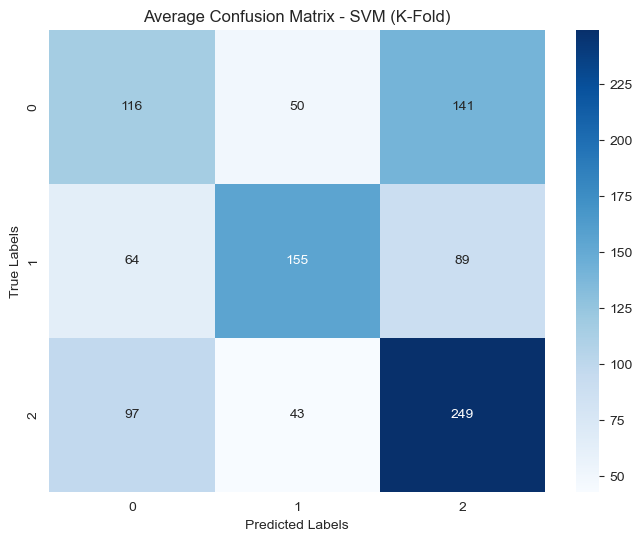

In [305]:
svm_model, svm_result = train_and_evaluate_model(X_train, y_train, X_test, y_test, model_type='svm')

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Summarizing Results Across All Folds
Average Test Accuracy: 0.5161
Average Precision: 0.5156
Average Recall: 0.5161
Average F1-Score: 0.5103
Average Test Accuracy: 0.5050
Average Precision: 0.5006
Average Recall: 0.5050
Average F1-Score: 0.4967

Average Classification Report:
Label 0:
  precision: 0.4384
  recall: 0.3566
  f1-score: 0.3932
  support: 309.0000
Label 1:
  precision: 0.5943
  recall: 0.5049
  f1-score: 0.5459
  support: 309.0000
Label 2:
  precision: 0.5144
  recall: 0.6511
  f1-score: 0.5748
  support: 390.4000


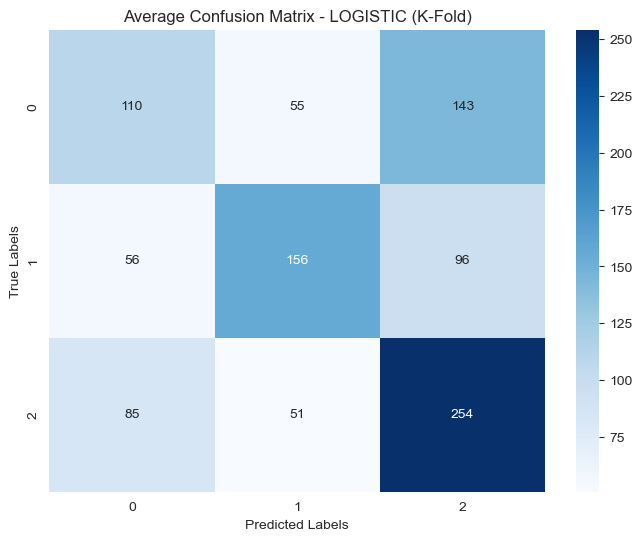

In [306]:
lr_model, lr_result = train_and_evaluate_model(X_train, y_train, X_test, y_test, model_type='logistic')

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Summarizing Results Across All Folds
Average Test Accuracy: 0.5083
Average Precision: 0.5107
Average Recall: 0.5083
Average F1-Score: 0.5092
Average Test Accuracy: 0.4988
Average Precision: 0.4964
Average Recall: 0.4988
Average F1-Score: 0.4968

Average Classification Report:
Label 0:
  precision: 0.4117
  recall: 0.4304
  f1-score: 0.4207
  support: 309.0000
Label 1:
  precision: 0.5705
  recall: 0.5495
  f1-score: 0.5596
  support: 309.0000
Label 2:
  precision: 0.5417
  recall: 0.5374
  f1-score: 0.5394
  support: 390.4000


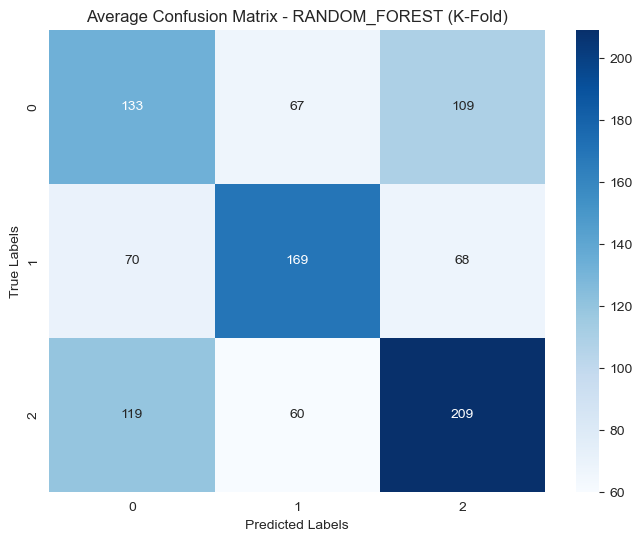

In [307]:
rf_model, rf_result = train_and_evaluate_model(X_train, y_train, X_test, y_test, model_type='random_forest')



Overall Result:
      model_type  avg_accuracy  avg_precision  avg_recall    avg_f1
0            svm      0.516859       0.519930    0.516859  0.513573
1       logistic      0.516066       0.515610    0.516066  0.510273
2  random_forest      0.508331       0.510674    0.508331  0.509221


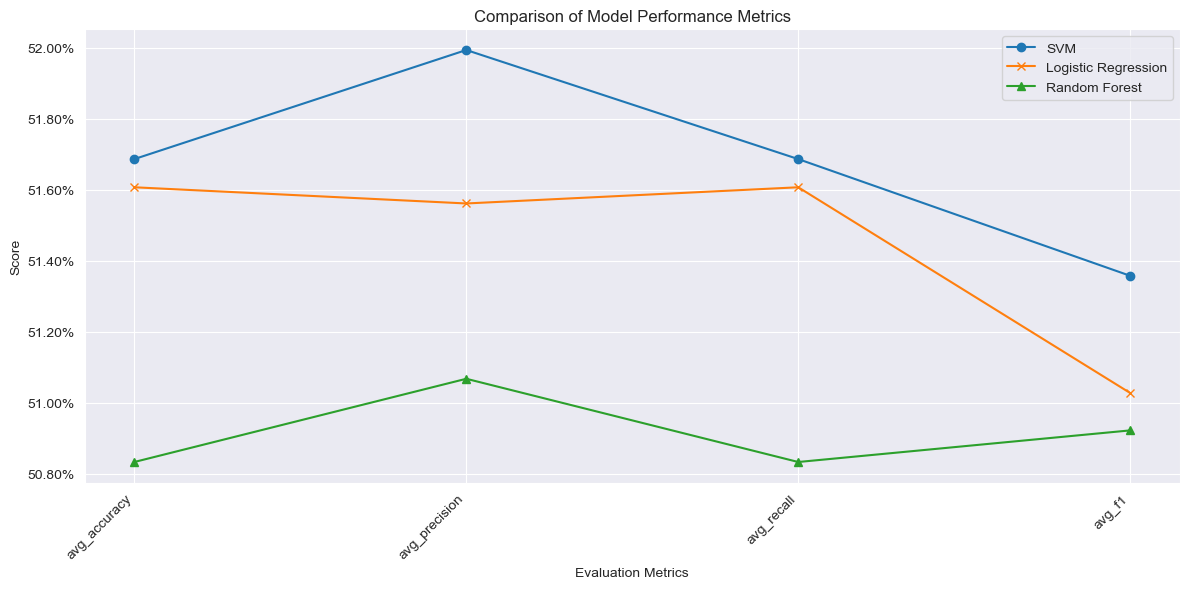

In [308]:
results_df = pd.DataFrame([svm_result, lr_result, rf_result])
print("\n\nOverall Result:")
print(results_df)

def plot_results(results_df):
    metrics = ['avg_accuracy', 'avg_precision', 'avg_recall', 'avg_f1']
    x_ticks = np.arange(len(metrics))
    plt.figure(figsize=(12, 6))
    plt.plot(x_ticks, results_df.loc[results_df['model_type'] == 'svm', metrics].values[0], label='SVM', marker='o')
    plt.plot(x_ticks, results_df.loc[results_df['model_type'] == 'logistic', metrics].values[0], label='Logistic Regression', marker='x')
    plt.plot(x_ticks, results_df.loc[results_df['model_type'] == 'random_forest', metrics].values[0], label='Random Forest', marker='^')
    plt.xlabel('Evaluation Metrics')
    plt.ylabel('Score')
    plt.title('Comparison of Model Performance Metrics')
    plt.xticks(x_ticks, metrics, rotation=45, ha = 'right')
    plt.legend()
    plt.grid(True)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.tight_layout()
    plt.show()

plot_results(results_df)

In [267]:
class SentimentDataset(Dataset):
    def __init__(self, sentences, labels):
        self.sentences = sentences
        self.labels = labels

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.sentences[idx], self.labels[idx]

train_dataset = SentimentDataset(vectorized_train_sentences, train_labels_tensor)
test_dataset = SentimentDataset(vectorized_test_sentences, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [268]:
class FullyConnectedModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, dense_units, dropout, l2_reg, batch_normalization, output_dim, kernel_initializer='he_uniform'):
        super(FullyConnectedModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.flatten = nn.Flatten()
        self.batch_norm1 = nn.BatchNorm1d(dense_units*2) if batch_normalization else None
        self.batch_norm2 = nn.BatchNorm1d(dense_units) if batch_normalization else None

        if kernel_initializer == 'he_uniform':
          init_weights = lambda m: nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        elif kernel_initializer == 'he_normal':
          init_weights = lambda m: nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        else: #default
           init_weights = None
        self.fc1 = nn.Linear(embedding_dim * MAX_LENGTH, dense_units * 2)
        if init_weights:
          self.fc1.apply(init_weights)
        self.dropout1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(dense_units * 2, dense_units)
        if init_weights:
          self.fc2.apply(init_weights)
        self.dropout2 = nn.Dropout(dropout)

        self.fc_out = nn.Linear(dense_units, output_dim)
    def forward(self, x):
        embedded = self.embedding(x)
        flattened = self.flatten(embedded)
        x = self.fc1(flattened)
        if self.batch_norm1:
          x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        if self.batch_norm2:
          x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        out = self.fc_out(x)
        return out

In [269]:
def train_model_fc(model, train_loader, optimizer, criterion, device, epoch_losses=None):
    model.train()
    total_loss = 0
    for sentences, labels in train_loader:
        sentences = sentences.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(sentences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch_losses is not None:
      epoch_losses.append(total_loss / len(train_loader))
    return total_loss / len(train_loader)

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
      for sentences, labels in test_loader:
            sentences = sentences.to(device)
            labels = labels.to(device)
            outputs = model(sentences)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return total_loss / len(test_loader), correct / total, y_true, y_pred

In [270]:
import copy
def cross_validate_model(model_creation_fn, X, y, params, cv, device, vocab_size):
    label_encoder = LabelEncoder()
    encoded_y = label_encoder.fit_transform(y)
    params.pop('epochs', None)
    params.pop('batch_size', None)
    output_dim = len(set(encoded_y))
    model = model_creation_fn(vocab_size=vocab_size, **params, output_dim=output_dim).to(device) # Create model
    best_acc = 0;
    best_model = None;
    y_true_all = []
    y_pred_all = []
    all_fold_losses = []
    for fold, (train_index, val_index) in enumerate(cv.split(X, y)):
        X_train = X[train_index]
        y_train = torch.tensor(encoded_y[train_index], dtype=torch.long)
        X_val = X[val_index]
        y_val = torch.tensor(encoded_y[val_index], dtype=torch.long)
        train_dataset = SentimentDataset(X_train, y_train)
        val_dataset = SentimentDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        model_clone = copy.deepcopy(model)
        optimizer = optim.Adam(model_clone.parameters(), lr=params.get('learning_rate', 0.001))
        criterion = nn.CrossEntropyLoss()
        epoch_losses = []
        for epoch in range(10):
            train_model_fc(model_clone, train_loader, optimizer, criterion, device, epoch_losses) # save the epoch loss for this fold
        _, val_acc, y_true, y_pred = evaluate_model(model_clone, val_loader, criterion, device)
        y_true_all.extend(y_true)
        y_pred_all.extend(y_pred)
        all_fold_losses.append(epoch_losses)
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = copy.deepcopy(model_clone)
    results = calculate_results(y_true_all, y_pred_all)
    cm = confusion_matrix(y_true_all, y_pred_all, labels = np.unique(encoded_y))
    print(f"\nCross Validation Results:")
    for metric, score in results.items():
      print(f"- {metric.capitalize()}: {score:.2f}")
    return results, cm, label_encoder.classes_, all_fold_losses, best_model

In [271]:
def filter_param_dist_for_model(model_creation_fn, param_dist):
    valid_params = signature(model_creation_fn).parameters.keys()
    filtered_param_dist = {key: value for key, value in param_dist.items() if key in valid_params}
    return filtered_param_dist
def perform_random_search(model_creation_fn, param_dist, X_train, y_train, X_val, y_val, n_iter,  device, vocab_size):
    best_val_acc = 0.0
    best_params = {}
    filtered_param_dist = filter_param_dist_for_model(model_creation_fn, param_dist)
    history = []
    train_dataset = SentimentDataset(X_train, y_train)
    val_dataset = SentimentDataset(X_val, y_val)
    for i in range(n_iter):
        params = {key: np.random.choice(value) for key, value in filtered_param_dist.items()}
        current_epochs = 5
        current_batch_size = 32
        print(f"-------------------")
        print(f"Training with params: {params}, epochs: {current_epochs}, batch_size: {current_batch_size}")
        train_loader = DataLoader(train_dataset, batch_size=int(current_batch_size), shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=int(current_batch_size), shuffle=False)
        output_dim = len(set(train_labels_tensor.tolist()))
        model = model_creation_fn(vocab_size=vocab_size, **params, output_dim=output_dim).to(device)
        optimizer = optim.Adam(model.parameters(), lr=params.get('learning_rate', 0.001))
        criterion = nn.CrossEntropyLoss()
        epoch_train_losses = []
        epoch_val_losses = []
        epoch_val_accs = []
        for epoch in range(current_epochs):
            train_loss = train_model_fc(model, train_loader, optimizer, criterion, device)
            val_loss, val_acc, _, _ = evaluate_model(model, val_loader, criterion, device)
            print(f'Epoch {epoch + 1}/{current_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
            epoch_train_losses.append(train_loss)
            epoch_val_losses.append(val_loss)
            epoch_val_accs.append(val_acc)
        history.append({
           'params': params,
           'epochs': current_epochs,
           'batch_size': current_batch_size,
           'train_losses': epoch_train_losses,
           'val_losses': epoch_val_losses,
           'val_accs': epoch_val_accs
        })
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params
            best_params['epochs'] = current_epochs
            best_params['batch_size'] = int(current_batch_size)
    print("\n-----Best Parameters Found------")
    print(f"Best validation accuracy: {best_val_acc}")
    print(f"Best parameters: {best_params}")
    return best_params, history

In [272]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
def calculate_results(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)
    return {
        "avg_accuracy": accuracy,
        "avg_precision": precision,
        "avg_recall": recall,
        "avg_f1": f1
    }
def display_dl_results(model, model_name, X_val, y_val, device):
    model.eval()
    with torch.no_grad():
        y_pred = []
        for sentences, labels in DataLoader(SentimentDataset(X_val, y_val), batch_size=32):
            sentences = sentences.to(device)
            outputs = model(sentences)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
    results = calculate_results(y_val.cpu().numpy(), y_pred)
    print(f"\n{model_name} Validation Data Results:")
    for metric, score in results.items():
        print(f"- {metric.capitalize()}: {score:.2f}")
    return results

In [273]:
def visualize_tuning_history(history):
    num_trials = len(history)
    fig, axes = plt.subplots(num_trials, 2, figsize = (12, 4*num_trials), dpi = 100)
    if num_trials ==1:
      axes = np.array([axes])

    for i, trial in enumerate(history):
       trial_params = trial['params']
       trial_epochs = trial['epochs']
       trial_batch_size = trial['batch_size']
       trial_train_losses = trial['train_losses']
       trial_val_losses = trial['val_losses']
       trial_val_accs = trial['val_accs']

       ax1 = axes[i, 0]
       ax1.plot(range(1,trial_epochs+1), trial_train_losses, label='Train Loss', marker='o')
       ax1.plot(range(1,trial_epochs+1), trial_val_losses, label='Val Loss', marker='o')
       ax1.set_xlabel('Epoch')
       ax1.set_ylabel('Loss')
       ax1.set_title(f'Loss with params: {trial_params} \n epochs={trial_epochs}, batch_size={trial_batch_size}')
       ax1.legend()

       ax2 = axes[i, 1]
       ax2.plot(range(1, trial_epochs+1), trial_val_accs, label="Val Acc", color='green', marker='o')
       ax2.set_xlabel('Epoch')
       ax2.set_ylabel('Validation Accuracy')
       ax2.set_title('Validation Accuracy')
       ax2.legend()
    plt.tight_layout()
    plt.show()

In [274]:
import matplotlib.ticker as ticker

def visualize_best_model_training(tuning_history, model_name):
    plt.figure(figsize=(18, 6))
    plt.suptitle(f'Training History of the {model_name} - Best Model', fontsize = 16)
    all_train_losses = []
    all_val_losses = []
    all_val_accs = []
    best_acc = 0
    best_idx = 0

    for idx, history in enumerate(tuning_history):
        all_train_losses.append(history['train_losses'])
        all_val_losses.append(history['val_losses'])
        all_val_accs.append(history['val_accs'])
        if max(history['val_accs']) > best_acc:
            best_acc = max(history['val_accs'])
            best_idx = idx

    num_epochs = len(all_train_losses[0])
    x_epochs = range(1, num_epochs + 1) 

    ax1 = plt.subplot(1, 3, 1)
    for idx, losses in enumerate(all_train_losses):
         if idx == best_idx:
           ax1.plot(x_epochs, losses, marker='o', label=f'Best Train Loss')
         else:
           ax1.plot(x_epochs, losses, alpha=0.3, label = f'Other train loss')
    ax1.set_title('Train Loss per Trial', fontsize = 14)
    ax1.set_xlabel('Epochs', fontsize = 12)
    ax1.set_ylabel('Loss', fontsize = 12)
    ax1.grid(True)
    ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    ax2 = plt.subplot(1, 3, 2)
    for idx, losses in enumerate(all_val_losses):
       if idx == best_idx:
         ax2.plot(x_epochs, losses, marker='o', label=f'Best Val Loss')
       else:
         ax2.plot(x_epochs, losses, alpha=0.3, label = f'Other val loss')
    ax2.set_title('Validation Loss per Trial', fontsize = 14)
    ax2.set_xlabel('Epochs', fontsize = 12)
    ax2.set_ylabel('Loss', fontsize = 12)
    ax2.grid(True)
    ax2.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    # Validation Accuracy Plot
    ax3 = plt.subplot(1, 3, 3)
    for idx, accs in enumerate(all_val_accs):
      if idx == best_idx:
        ax3.plot(x_epochs, accs, marker='o', label=f'Best Val Acc')
      else:
        ax3.plot(x_epochs, accs, alpha=0.3, label = f'Other val acc')
    ax3.set_title('Validation Accuracy per Trial', fontsize = 14)
    ax3.set_xlabel('Epochs', fontsize=12)
    ax3.set_ylabel('Accuracy', fontsize=12)
    ax3.grid(True)
    ax3.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Add padding
    plt.show()

In [295]:
def visualize_best_model_final_training(model_name, results, cm, labels):
    plt.figure(figsize=(18, 6))
    ax3 = plt.subplot(1, 3, 3)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax3,
               xticklabels=labels, yticklabels=labels)
    ax3.set_title('Confusion Matrix', fontsize=14)
    ax3.set_xlabel('Predicted Labels', fontsize=12)
    ax3.set_ylabel('True Labels', fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [290]:
def visualize_cross_val_losses(all_fold_losses, model_name):
  plt.figure(figsize = (12,6))
  x_epochs = range(1, len(all_fold_losses[0]) + 1) # Get the number of epochs
  for fold, losses in enumerate(all_fold_losses):
      plt.plot(x_epochs, losses, label=f"Fold {fold+1}")
  plt.xlabel('Epochs', fontsize = 12)
  plt.ylabel('Loss', fontsize = 12)
  plt.grid(True)
  plt.legend()
  plt.show()

In [277]:
CV = ShuffleSplit(n_splits=5, test_size=0.1, random_state=42)
EPOCHS = 10
BATCH_SIZE = 32
param_dist = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'dense_units': [32, 64, 128],
    'dropout': [0.2, 0.3, 0.4, 0.5],
    'l2_reg': [0.001, 0.01, 0.1],
    'batch_normalization': [True, False],
    'kernel_initializer': ["he_uniform", 'he_normal'],
    'embedding_dim' : [100, 200]
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VOCAB_SIZE = len(token_to_index)
fc_model_best_params, tuning_history = perform_random_search(FullyConnectedModel,
                                            param_dist=param_dist,
                                            X_train=vectorized_train_sentences, y_train=train_labels_tensor,
                                            X_val=vectorized_test_sentences, y_val=test_labels_tensor,
                                            n_iter=10, device=device, vocab_size=VOCAB_SIZE)

-------------------
Training with params: {'dense_units': 128, 'dropout': 0.3, 'l2_reg': 0.001, 'batch_normalization': False, 'kernel_initializer': 'he_normal', 'embedding_dim': 100}, epochs: 5, batch_size: 32
Epoch 1/5, Train Loss: 1.1541, Val Loss: 1.0758, Val Acc: 0.4049
Epoch 2/5, Train Loss: 1.0235, Val Loss: 1.1122, Val Acc: 0.3522
Epoch 3/5, Train Loss: 0.9682, Val Loss: 1.1040, Val Acc: 0.3958
Epoch 4/5, Train Loss: 0.9083, Val Loss: 1.1457, Val Acc: 0.3977
Epoch 5/5, Train Loss: 0.8710, Val Loss: 1.1636, Val Acc: 0.3929
-------------------
Training with params: {'dense_units': 32, 'dropout': 0.5, 'l2_reg': 0.1, 'batch_normalization': True, 'kernel_initializer': 'he_uniform', 'embedding_dim': 200}, epochs: 5, batch_size: 32
Epoch 1/5, Train Loss: 1.1377, Val Loss: 1.0809, Val Acc: 0.4102
Epoch 2/5, Train Loss: 1.0861, Val Loss: 1.0837, Val Acc: 0.4068
Epoch 3/5, Train Loss: 1.0596, Val Loss: 1.0830, Val Acc: 0.3872
Epoch 4/5, Train Loss: 1.0214, Val Loss: 1.0820, Val Acc: 0.406

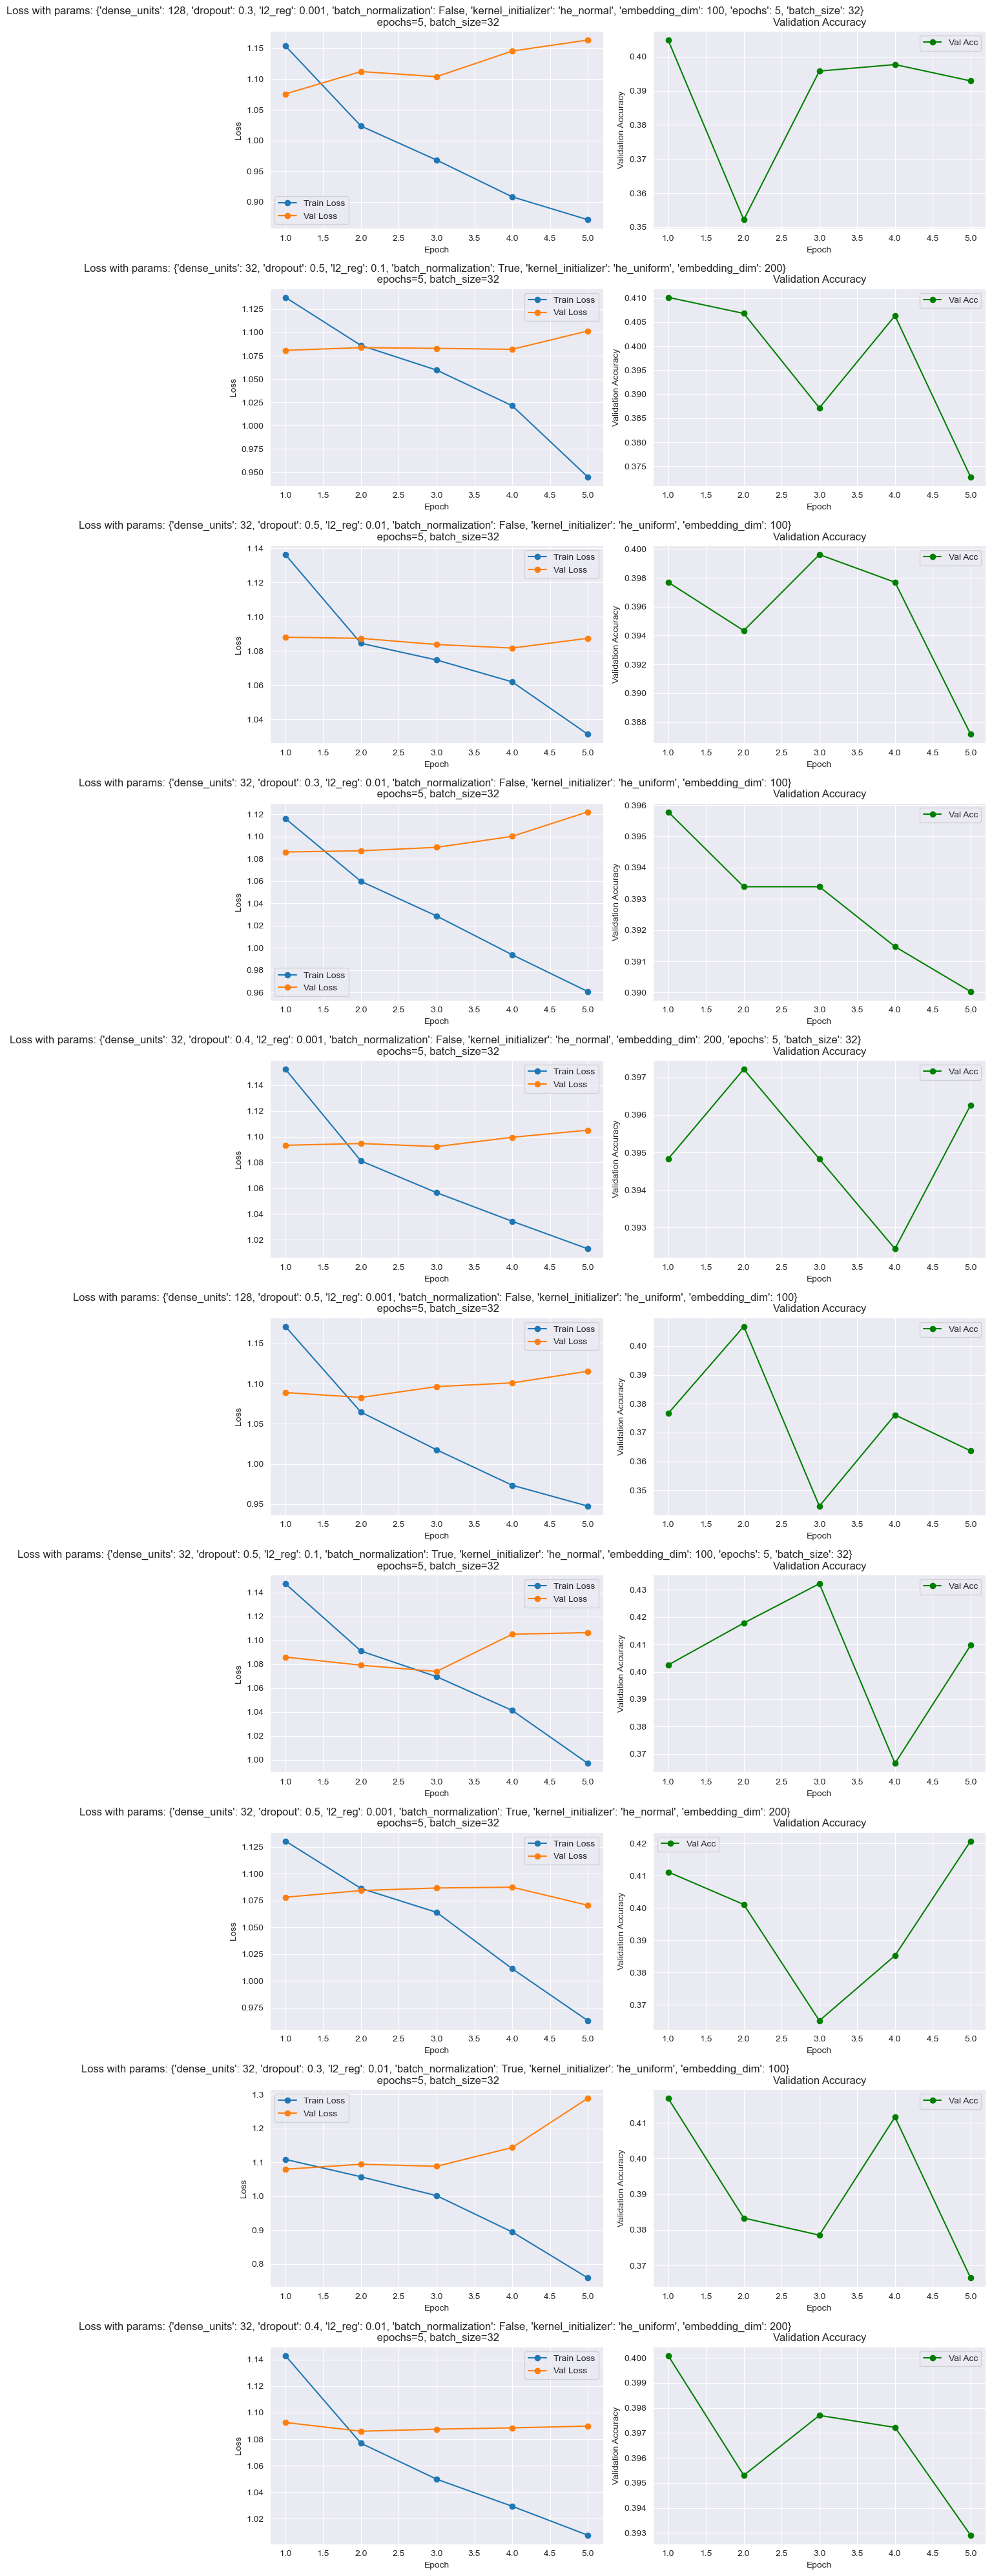

In [286]:
visualize_tuning_history(tuning_history)

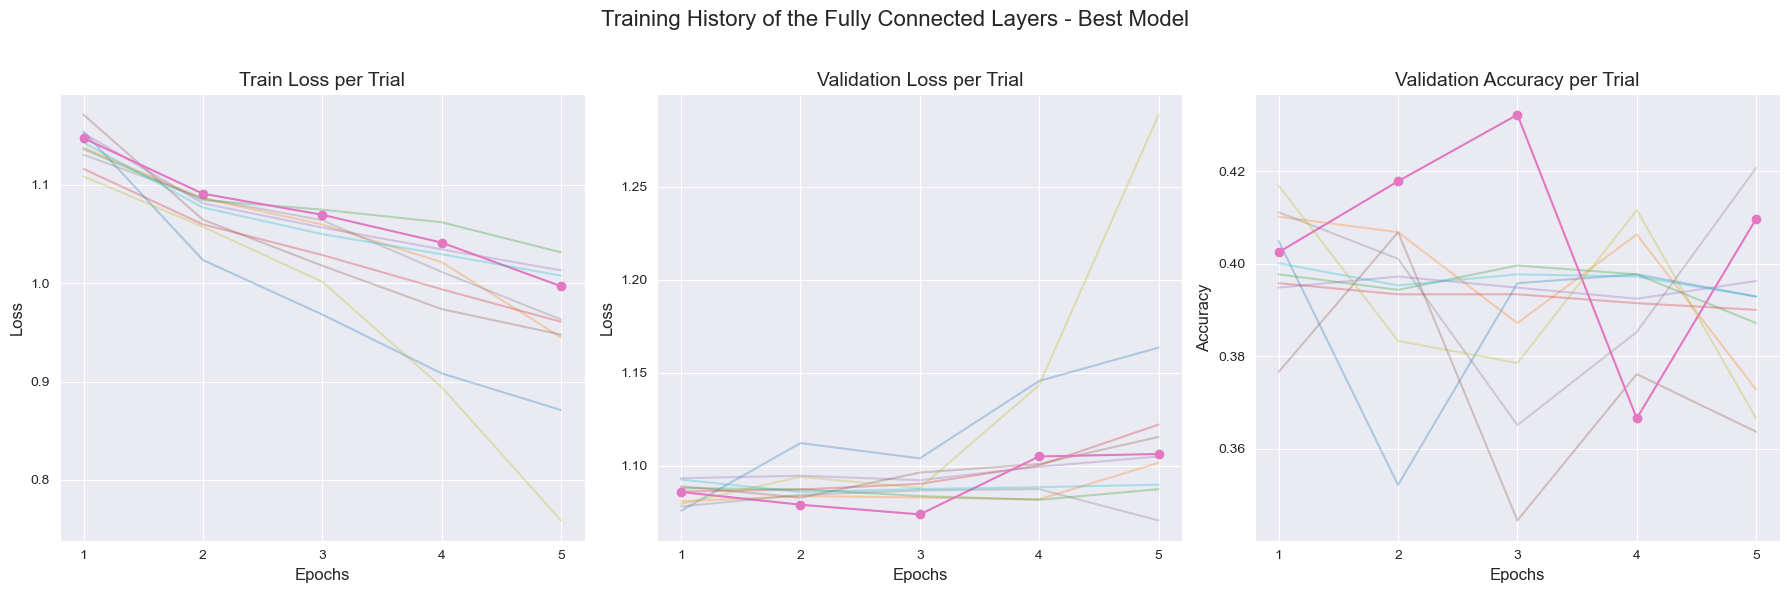

In [279]:
visualize_best_model_training(tuning_history, model_name='Fully Connected Layers')

In [280]:
cv_results, cm, labels, all_fold_losses, fc_model = cross_validate_model(FullyConnectedModel,
                                       vectorized_all,
                                        labels_all_tensor,
                                        fc_model_best_params,
                                         CV, device, VOCAB_SIZE)


Cross Validation Results:
- Avg_accuracy: 0.43
- Avg_precision: 0.44
- Avg_recall: 0.43
- Avg_f1: 0.43


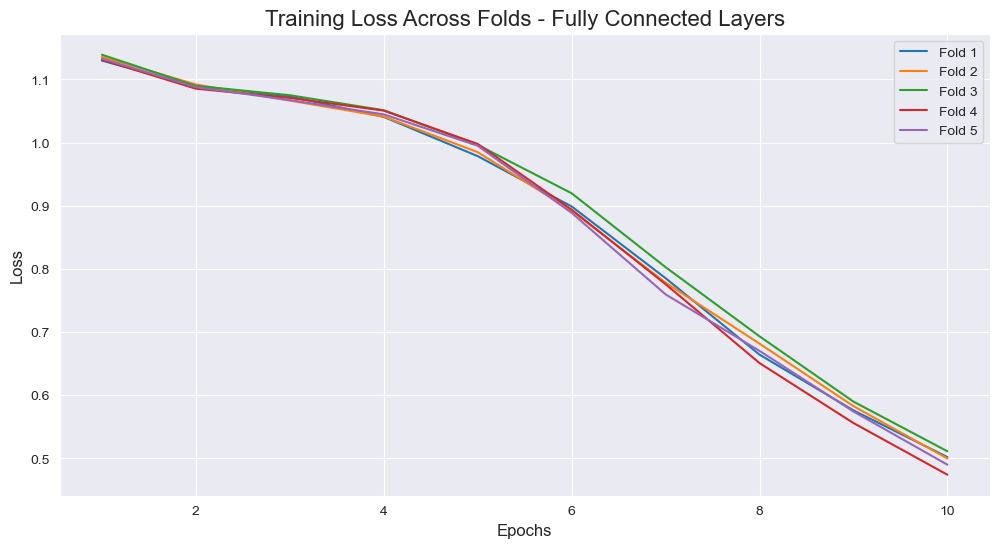

In [281]:
visualize_cross_val_losses(all_fold_losses, model_name='Fully Connected Layers')

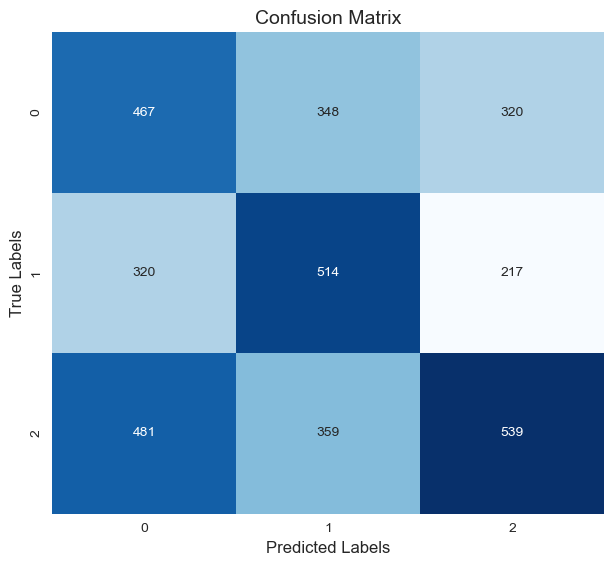

In [296]:
visualize_best_model_final_training(all_fold_losses, results=cv_results, cm = cm, labels = labels)



Overall Result:
      model_type  avg_accuracy  avg_precision  avg_recall    avg_f1
0            svm      0.516859       0.519930    0.516859  0.513573
1       logistic      0.516066       0.515610    0.516066  0.510273
2  random_forest      0.508331       0.510674    0.508331  0.509221
3       fc_model      0.426367       0.435129    0.426367  0.426989


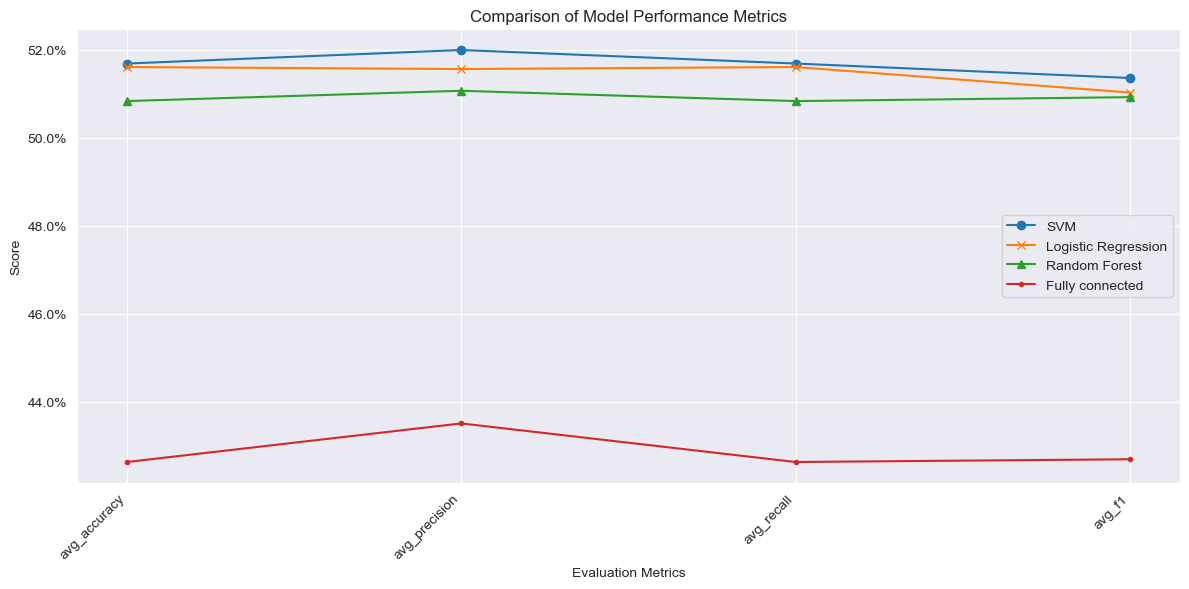

In [309]:
cv_results['model_type'] = 'fc_model'
results_df = pd.DataFrame([svm_result, lr_result, rf_result, cv_results])

print("\n\nOverall Result:")
print(results_df)


import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

def plot_results(results_df):
    metrics = ['avg_accuracy', 'avg_precision', 'avg_recall', 'avg_f1']
    x_ticks = np.arange(len(metrics))
    plt.figure(figsize=(12, 6))
    plt.plot(x_ticks, results_df.loc[results_df['model_type'] == 'svm', metrics].values[0], label='SVM', marker='o')
    plt.plot(x_ticks, results_df.loc[results_df['model_type'] == 'logistic', metrics].values[0], label='Logistic Regression', marker='x')
    plt.plot(x_ticks, results_df.loc[results_df['model_type'] == 'random_forest', metrics].values[0], label='Random Forest', marker='^')
    plt.plot(x_ticks, results_df.loc[results_df['model_type'] == 'fc_model', metrics].values[0], label = 'Fully connected', marker = '.')
    plt.xlabel('Evaluation Metrics')
    plt.ylabel('Score')
    plt.title('Comparison of Model Performance Metrics')
    plt.xticks(x_ticks, metrics, rotation=45, ha = 'right')
    plt.legend()
    plt.grid(True)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.tight_layout()
    plt.show()

plot_results(results_df)

Evaluation of Voting model:
Test accuracy: 0.5678006708193579
Label 0:
  precision: 0.5255
  recall: 0.4692
  f1-score: 0.4957
  support: 682.0000
Label 1:
  precision: 0.6442
  recall: 0.4877
  f1-score: 0.5551
  support: 568.0000
Label 2:
  precision: 0.5611
  recall: 0.7025
  f1-score: 0.6239
  support: 837.0000


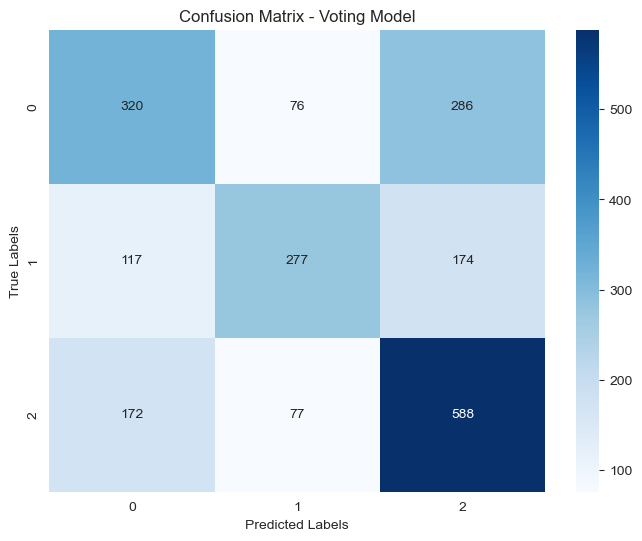

In [298]:
def predict_with_voting(X_test, models, batch_size=32):
    """Dự đoán bằng cách lấy nhãn được dự đoán nhiều nhất (voting)."""
    svm_model, rf_model, lr_model, fc_model = models

    svm_preds = svm_model.predict(X_test)
    rf_preds = rf_model.predict(X_test)
    lr_preds = lr_model.predict(X_test)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    fc_preds = []
    with torch.no_grad():
      fc_model.eval()
      test_dataset_fc = SentimentDataset(vectorized_test_sentences, test_labels_tensor)
      test_loader_fc = DataLoader(test_dataset_fc, batch_size=batch_size, shuffle=False)
      for sentences, _ in test_loader_fc:
        sentences = sentences.to(device)
        outputs = fc_model(sentences)
        _, predicted = torch.max(outputs, 1)
        fc_preds.extend(predicted.cpu().numpy())

    predictions = np.array([svm_preds, rf_preds, lr_preds, fc_preds])

    # Take the mode of each row
    final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

    return final_predictions

def evaluate_voting_manual(X_test, y_test, models):
    y_pred_test = predict_with_voting(X_test, models)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_report = classification_report(y_test, y_pred_test, output_dict = True)
    test_conf_matrix = confusion_matrix(y_test, y_pred_test)

    print("Evaluation of Voting model:")
    print(f"Test accuracy: {test_accuracy}")
    for label in test_report:
            if label not in ["accuracy", "macro avg", "weighted avg", "support"]:
                print(f"Label {label}:")
                for metric, score in test_report[label].items():
                 print(f"  {metric}: {score:.4f}")
    # Visualize Average Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix - Voting Model")
    plt.show()
    return test_accuracy, test_report

# Evaluate the voting mechanism
models = [svm_model, rf_model, lr_model, fc_model]
test_accuracy, test_report = evaluate_voting_manual(X_test, y_test, models)

In [299]:
def predict_with_voting(X_test, models, batch_size=32):
    """Dự đoán bằng cách lấy nhãn được dự đoán nhiều nhất (voting)."""
    svm_model, rf_model, lr_model, fc_model = models

    svm_preds = svm_model.predict(X_test)
    rf_preds = rf_model.predict(X_test)
    lr_preds = lr_model.predict(X_test)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    fc_preds = []
    with torch.no_grad():
        fc_model.eval()
        # In case of single sample prediction, ensure the same length of input for the FC model
        if X_test.shape[0] == 1:
            # Get the original text from the dataframe using the correct index
            original_text = df.iloc[X_test.nonzero()[0][0]]['corpus']
            vectorized_X_test = [text_to_indices(original_text, token_to_index, MAX_LENGTH)]
        else:
            # For multiple samples, get the original texts based on non-zero indices
            original_texts = df.iloc[X_test.nonzero()[0]]['corpus'].tolist()
            vectorized_X_test = [text_to_indices(text, token_to_index, MAX_LENGTH) for text in original_texts]

        test_dataset_fc = SentimentDataset(torch.stack(vectorized_X_test), torch.tensor([0] * len(vectorized_X_test)))  # Use dummy labels
        test_loader_fc = DataLoader(test_dataset_fc, batch_size=batch_size, shuffle=False)

        for sentences, _ in test_loader_fc:
            sentences = sentences.to(device)
            outputs = fc_model(sentences)
            _, predicted = torch.max(outputs, 1)
            fc_preds.extend(predicted.cpu().numpy())

    predictions = np.array([svm_preds, rf_preds, lr_preds, fc_preds])

    # Take the mode of each row
    final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

    return final_predictions

def evaluate_voting_manual(X_test, y_test, models):
    y_pred_test = predict_with_voting(X_test, models)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_report = classification_report(y_test, y_pred_test, output_dict = True)
    test_conf_matrix = confusion_matrix(y_test, y_pred_test)

    print("Evaluation of Voting model:")
    print(f"Test accuracy: {test_accuracy}")
    for label in test_report:
            if label not in ["accuracy", "macro avg", "weighted avg", "support"]:
                print(f"Label {label}:")
                for metric, score in test_report[label].items():
                 print(f"  {metric}: {score:.4f}")
    # Visualize Average Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix - Voting Model")
    plt.show()
    return test_accuracy, test_report

# Lấy ngẫu nhiên 10 hàng
sample_df = df.sample(10)

# Evaluate the voting mechanism
models = [svm_model, rf_model, lr_model, fc_model]

for index, row in sample_df.iterrows():
    print(f"\n--- Row {index} ---")
    print(f"Content: {row['content']}")
    print(f"Label: {row['label']}")
    print(f"Corpus: {row['corpus']}")

    # Vectorize
    X_sample = vectorizer.transform([row['corpus']])

    # Dự đoán
    y_pred_sample = predict_with_voting(X_sample, models)

    print(f"Predicted label (voting): {y_pred_sample[0]}")


--- Row 4686 ---
Content: Tất cả thị trường tài chính đều là trò chơi của cá mập , ko riêng gì thị trường crypto.
Label: 1
Corpus: tất_cả thị_trường tài_chính trò_chơi cá_mập thị_trường crypto
Predicted label (voting): 1

--- Row 6635 ---
Content: trí tuệ nhân tạo do con người lập trình nên sẽ mãi không bao giờ thay thế được trí tuệ thật của loài người, nếu phụ thuộc vào nó quá thì con người sẽ bị giảm tư duy và lệ thuộc vào nó.
Label: 0
Corpus: trí_tuệ nhân_tạo con_người lập_trình mãi bao_giờ thay_thế trí_tuệ loài_người phụ_thuộc con_người tư_duy lệ_thuộc
Predicted label (voting): 0

--- Row 4902 ---
Content: Rất nhiều điều Phụ nữ làm được mà đàn ông không làm được và ngược lại . Hai người đến với nhau, là để bổ xung, chia sẻ vui buồn chứ không phải coi mọi thứ chỉ như nghĩa vụ hay quyền lợi.
Label: 2
Corpus: phụ_nữ đàn_ông ngược_lại hai bổ xung chia_sẻ vui buồn coi nghĩa_vụ quyền_lợi
Predicted label (voting): 2

--- Row 5257 ---
Content: Bạn hướng dẫn nhưng có học sinh không làm the